<a href="https://colab.research.google.com/github/koleshjr/Swahili_News_Nlp/blob/main/Vaccinate_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TO VACCINATE OR NOT VACCINATE

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, accuracy_score

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image

import spacy
import en_core_web_sm

import random
import warnings
warnings.filterwarnings('ignore')
import time
import datetime

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)


seed_val =42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Loading the Dataset

In [4]:
path = '/content/gdrive/MyDrive/vaccinate/'
train =pd.read_csv(path + 'Train.csv')
test =pd.read_csv(path + 'Test.csv')

display(train.head(), test.head())

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


In [5]:
train['label'].value_counts()

 0.000000    4908
 1.000000    4053
-1.000000    1038
 0.666667       1
Name: label, dtype: int64

remove the label with only one value because it is likely an outlier

In [6]:
train = train.dropna()
train['label'].value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

In [7]:
train.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [8]:
train['label'].unique()

array([ 0.,  1., -1.])

In [9]:
train['agreement'].value_counts()

1.000000    5866
0.666667    3894
0.333333     239
Name: agreement, dtype: int64

So this is a regression problem


### Text Cleaning

In [10]:
## Remove URLS, htmls, emojis and punctuations
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

train['safe_text'] = train['safe_text'].apply(lambda x: remove_URL(x))
train['safe_text'] = train['safe_text'].apply(lambda x: remove_emoji(x))
train['safe_text'] = train['safe_text'].apply(lambda x: remove_html(x))
train['safe_text'] = train['safe_text'].apply(lambda x: remove_punct(x))

In [11]:
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me The Big Homie meanboy3000 MEANBOY MB MBS M...,0.0,1.0
1,E3303EME,Im 100 thinking of devoting my career to provi...,1.0,1.0
2,M4IVFSMS,whatcausesautism VACCINES DO NOT VACCINATE YOU...,-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to Catch me performing at La Nuit NYC ...,0.0,1.0


Tokenization

In [12]:
train['tokenized'] = train['safe_text'].apply(word_tokenize)
train.head()

,tweet_id,safe_text,label,agreement,tokenized
0,CL1KWCMY,Me The Big Homie meanboy3000 MEANBOY MB MBS M...,0.0,1.0,"[Me, The, Big, Homie, meanboy3000, MEANBOY, MB..."
1,E3303EME,Im 100 thinking of devoting my career to provi...,1.0,1.0,"[Im, 100, thinking, of, devoting, my, career, ..."
2,M4IVFSMS,whatcausesautism VACCINES DO NOT VACCINATE YOU...,-1.0,1.0,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,"[I, mean, if, they, immunize, my, kid, with, s..."
4,J77ENIIE,Thanks to Catch me performing at La Nuit NYC ...,0.0,1.0,"[Thanks, to, Catch, me, performing, at, La, Nu..."


Lower casing the tokens

In [13]:
train['lower'] = train['tokenized'].apply(
    lambda x: [word.lower() for word in x]
)
train.head()

,tweet_id,safe_text,label,agreement,tokenized,lower
0,CL1KWCMY,Me The Big Homie meanboy3000 MEANBOY MB MBS M...,0.0,1.0,"[Me, The, Big, Homie, meanboy3000, MEANBOY, MB...","[me, the, big, homie, meanboy3000, meanboy, mb..."
1,E3303EME,Im 100 thinking of devoting my career to provi...,1.0,1.0,"[Im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, of, devoting, my, career, ..."
2,M4IVFSMS,whatcausesautism VACCINES DO NOT VACCINATE YOU...,-1.0,1.0,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT...","[whatcausesautism, vaccines, do, not, vaccinat..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,"[I, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s..."
4,J77ENIIE,Thanks to Catch me performing at La Nuit NYC ...,0.0,1.0,"[Thanks, to, Catch, me, performing, at, La, Nu...","[thanks, to, catch, me, performing, at, la, nu..."


Removing Stop words

In [14]:
train['stops_removed'] = train['lower'].apply(
    lambda x: [word for word in x if word not in stop]
)

Part of speech tags

In [15]:
train['pos_tags'] = train['stops_removed'].apply(nltk.tag.pos_tag)
train.head()

,tweet_id,safe_text,label,agreement,tokenized,lower,stops_removed,pos_tags
0,CL1KWCMY,Me The Big Homie meanboy3000 MEANBOY MB MBS M...,0.0,1.0,"[Me, The, Big, Homie, meanboy3000, MEANBOY, MB...","[me, the, big, homie, meanboy3000, meanboy, mb...","[big, homie, meanboy3000, meanboy, mb, mbs, mm...","[(big, JJ), (homie, NN), (meanboy3000, NN), (m..."
1,E3303EME,Im 100 thinking of devoting my career to provi...,1.0,1.0,"[Im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, devoting, career, proving,...","[(im, NN), (100, CD), (thinking, VBG), (devoti..."
2,M4IVFSMS,whatcausesautism VACCINES DO NOT VACCINATE YOU...,-1.0,1.0,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, vaccinate, child]","[(whatcausesautism, NN), (vaccines, NNS), (vac..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,"[I, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wont, secretl...","[(mean, JJ), (immunize, VB), (kid, NNS), (some..."
4,J77ENIIE,Thanks to Catch me performing at La Nuit NYC ...,0.0,1.0,"[Thanks, to, Catch, me, performing, at, La, Nu...","[thanks, to, catch, me, performing, at, la, nu...","[thanks, catch, performing, la, nuit, nyc, 113...","[(thanks, NNS), (catch, VBP), (performing, VBG..."


Convert part of speech to wordnet format

In [16]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


train['wordnet_pos'] = train['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

train.head()

,tweet_id,safe_text,label,agreement,tokenized,lower,stops_removed,pos_tags,wordnet_pos
0,CL1KWCMY,Me The Big Homie meanboy3000 MEANBOY MB MBS M...,0.0,1.0,"[Me, The, Big, Homie, meanboy3000, MEANBOY, MB...","[me, the, big, homie, meanboy3000, meanboy, mb...","[big, homie, meanboy3000, meanboy, mb, mbs, mm...","[(big, JJ), (homie, NN), (meanboy3000, NN), (m...","[(big, a), (homie, n), (meanboy3000, n), (mean..."
1,E3303EME,Im 100 thinking of devoting my career to provi...,1.0,1.0,"[Im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, devoting, career, proving,...","[(im, NN), (100, CD), (thinking, VBG), (devoti...","[(im, n), (100, n), (thinking, v), (devoting, ..."
2,M4IVFSMS,whatcausesautism VACCINES DO NOT VACCINATE YOU...,-1.0,1.0,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, vaccinate, child]","[(whatcausesautism, NN), (vaccines, NNS), (vac...","[(whatcausesautism, n), (vaccines, n), (vaccin..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,"[I, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wont, secretl...","[(mean, JJ), (immunize, VB), (kid, NNS), (some...","[(mean, a), (immunize, v), (kid, n), (somethin..."
4,J77ENIIE,Thanks to Catch me performing at La Nuit NYC ...,0.0,1.0,"[Thanks, to, Catch, me, performing, at, La, Nu...","[thanks, to, catch, me, performing, at, la, nu...","[thanks, catch, performing, la, nuit, nyc, 113...","[(thanks, NNS), (catch, VBP), (performing, VBG...","[(thanks, n), (catch, v), (performing, v), (la..."


Word lemmatizer

In [17]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

train['lemmatized'] = train['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

train['lemmatized'] = train['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

train['lemma_str'] = [' '.join(map(str, l)) for l in train['lemmatized']]

train.head()

,tweet_id,safe_text,label,agreement,tokenized,lower,stops_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,CL1KWCMY,Me The Big Homie meanboy3000 MEANBOY MB MBS M...,0.0,1.0,"[Me, The, Big, Homie, meanboy3000, MEANBOY, MB...","[me, the, big, homie, meanboy3000, meanboy, mb...","[big, homie, meanboy3000, meanboy, mb, mbs, mm...","[(big, JJ), (homie, NN), (meanboy3000, NN), (m...","[(big, a), (homie, n), (meanboy3000, n), (mean...","[big, homie, meanboy3000, meanboy, mb, mb, mmr...",big homie meanboy3000 meanboy mb mb mmr stegma...
1,E3303EME,Im 100 thinking of devoting my career to provi...,1.0,1.0,"[Im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, devoting, career, proving,...","[(im, NN), (100, CD), (thinking, VBG), (devoti...","[(im, n), (100, n), (thinking, v), (devoting, ...","[im, 100, think, devote, career, prove, autism...",im 100 think devote career prove autism isnt c...
2,M4IVFSMS,whatcausesautism VACCINES DO NOT VACCINATE YOU...,-1.0,1.0,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, vaccinate, child]","[(whatcausesautism, NN), (vaccines, NNS), (vac...","[(whatcausesautism, n), (vaccines, n), (vaccin...","[whatcausesautism, vaccine, vaccinate, child]",whatcausesautism vaccine vaccinate child
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,"[I, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wont, secretl...","[(mean, JJ), (immunize, VB), (kid, NNS), (some...","[(mean, a), (immunize, v), (kid, n), (somethin...","[mean, immunize, kid, something, wont, secretl...",mean immunize kid something wont secretly kill...
4,J77ENIIE,Thanks to Catch me performing at La Nuit NYC ...,0.0,1.0,"[Thanks, to, Catch, me, performing, at, La, Nu...","[thanks, to, catch, me, performing, at, la, nu...","[thanks, catch, performing, la, nuit, nyc, 113...","[(thanks, NNS), (catch, VBP), (performing, VBG...","[(thanks, n), (catch, v), (performing, v), (la...","[thanks, catch, perform, la, nuit, nyc, 1134, ...",thanks catch perform la nuit nyc 1134 1st ave ...


### Data Visualization

#### Target Visualization

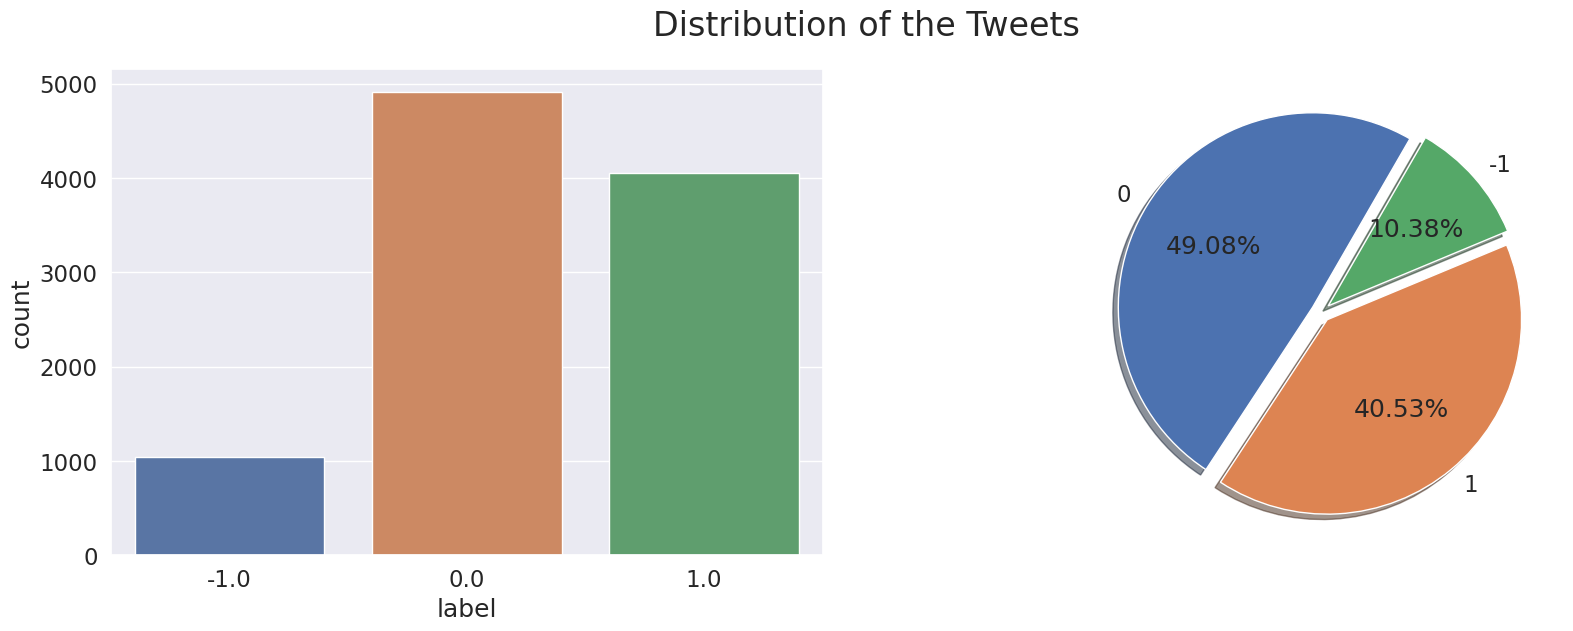

In [18]:


# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(train['label'], ax=axes[0])
axes[1].pie(train['label'].value_counts(),
            labels=['0', '1','-1'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0.05, 0.05),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()



#### Tweet Lengths

In [19]:
train.head()

,tweet_id,safe_text,label,agreement,tokenized,lower,stops_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,CL1KWCMY,Me The Big Homie meanboy3000 MEANBOY MB MBS M...,0.0,1.0,"[Me, The, Big, Homie, meanboy3000, MEANBOY, MB...","[me, the, big, homie, meanboy3000, meanboy, mb...","[big, homie, meanboy3000, meanboy, mb, mbs, mm...","[(big, JJ), (homie, NN), (meanboy3000, NN), (m...","[(big, a), (homie, n), (meanboy3000, n), (mean...","[big, homie, meanboy3000, meanboy, mb, mb, mmr...",big homie meanboy3000 meanboy mb mb mmr stegma...
1,E3303EME,Im 100 thinking of devoting my career to provi...,1.0,1.0,"[Im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, devoting, career, proving,...","[(im, NN), (100, CD), (thinking, VBG), (devoti...","[(im, n), (100, n), (thinking, v), (devoting, ...","[im, 100, think, devote, career, prove, autism...",im 100 think devote career prove autism isnt c...
2,M4IVFSMS,whatcausesautism VACCINES DO NOT VACCINATE YOU...,-1.0,1.0,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, vaccinate, child]","[(whatcausesautism, NN), (vaccines, NNS), (vac...","[(whatcausesautism, n), (vaccines, n), (vaccin...","[whatcausesautism, vaccine, vaccinate, child]",whatcausesautism vaccine vaccinate child
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,"[I, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wont, secretl...","[(mean, JJ), (immunize, VB), (kid, NNS), (some...","[(mean, a), (immunize, v), (kid, n), (somethin...","[mean, immunize, kid, something, wont, secretl...",mean immunize kid something wont secretly kill...
4,J77ENIIE,Thanks to Catch me performing at La Nuit NYC ...,0.0,1.0,"[Thanks, to, Catch, me, performing, at, La, Nu...","[thanks, to, catch, me, performing, at, la, nu...","[thanks, catch, performing, la, nuit, nyc, 113...","[(thanks, NNS), (catch, VBP), (performing, VBG...","[(thanks, n), (catch, v), (performing, v), (la...","[thanks, catch, perform, la, nuit, nyc, 1134, ...",thanks catch perform la nuit nyc 1134 1st ave ...


In [20]:
# Creating a new feature for the visualization.

train['Character Count'] = train['safe_text'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

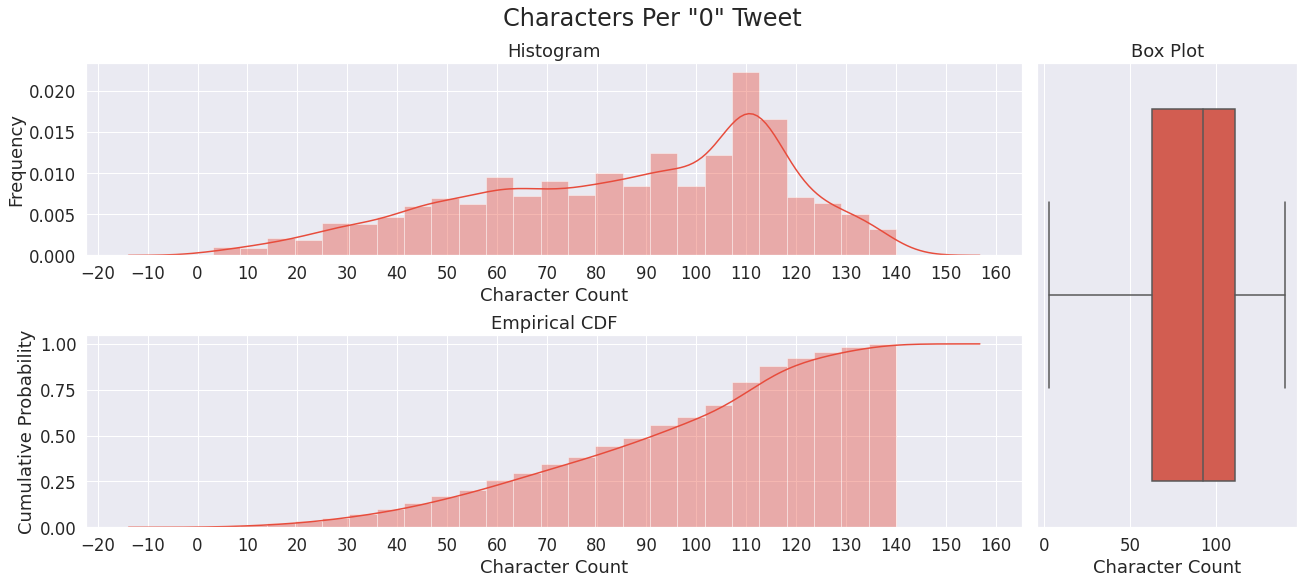

In [21]:
plot_dist3(train[train['label'] == 0], 'Character Count',
           'Characters Per "0" Tweet')

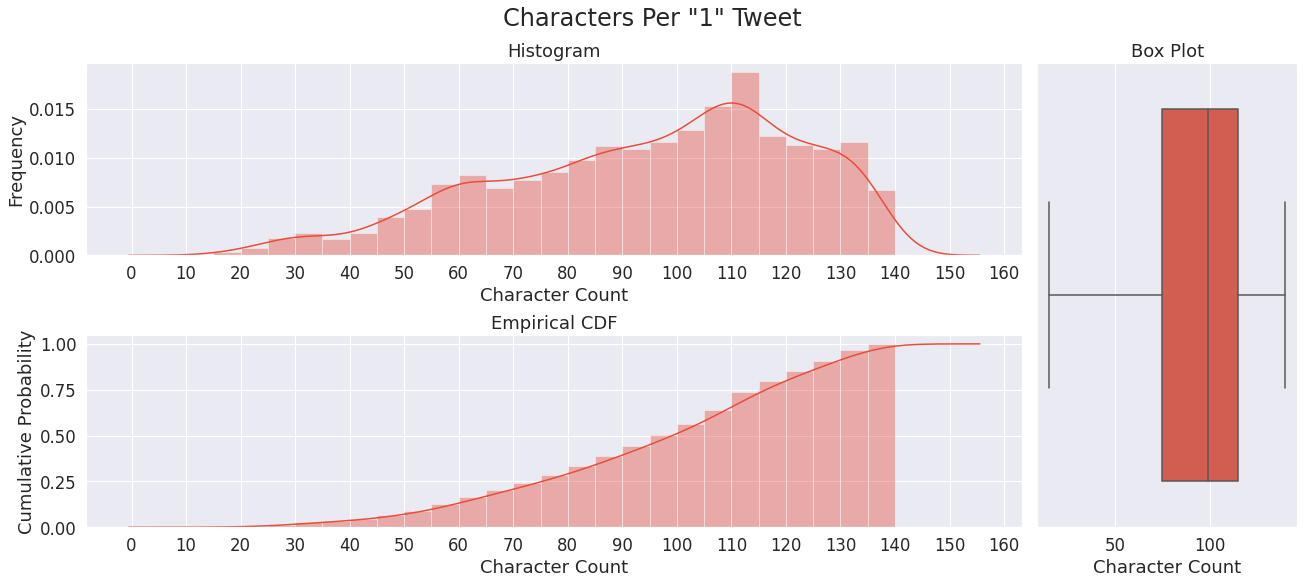

In [22]:
plot_dist3(train[train['label'] == 1], 'Character Count',
           'Characters Per "1" Tweet')

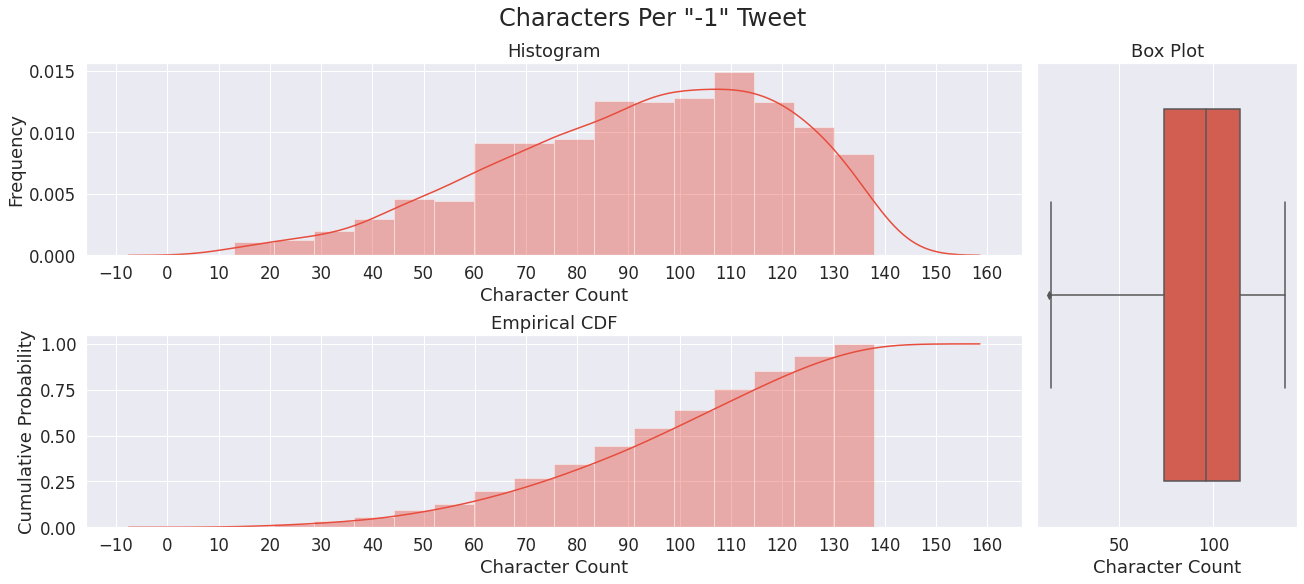

In [23]:
plot_dist3(train[train['label'] == -1], 'Character Count',
           'Characters Per "-1" Tweet')

#### Word Count

In [24]:
def plot_word_number_histogram(textno, textye, textun):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    sns.distplot(textun.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('0')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('1')
    axes[2].set_xlabel('Word Count')
    axes[2].set_title('-1')
    
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout()

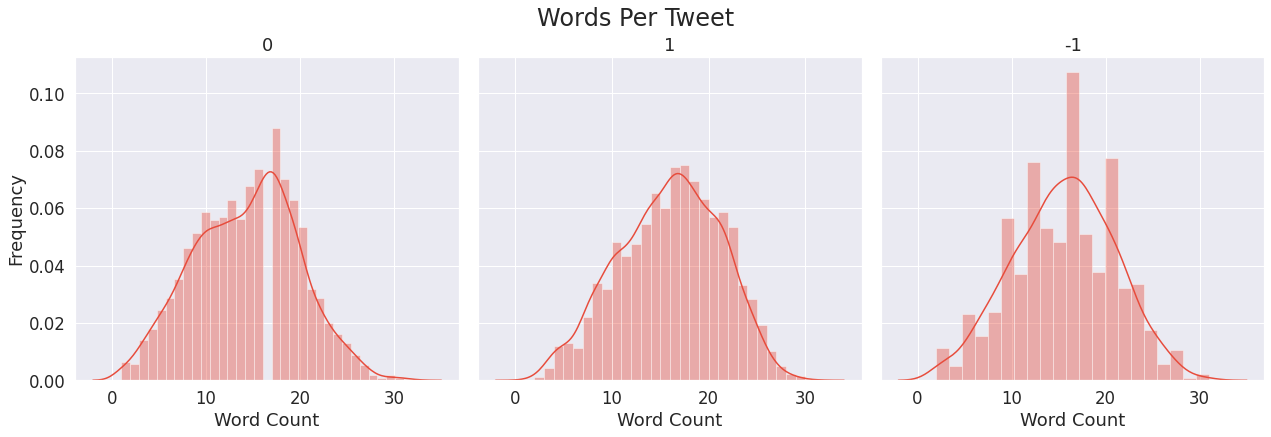

In [25]:
plot_word_number_histogram(train[train['label'] == 0]['safe_text'],
                           train[train['label'] == 1]['safe_text'],
                           train[train['label'] == -1]['safe_text'])

#### Word length

In [26]:
def plot_word_len_histogram(textno, textye, textna):
    
    """A function for comparing average word length"""
    
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[1], color='#e74c3c')
    sns.distplot(textna.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[2], color='#e74c3c')
    
    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('0')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('1')
    axes[2].set_xlabel('Word Length')
    axes[2].set_title('-1')
    
    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()

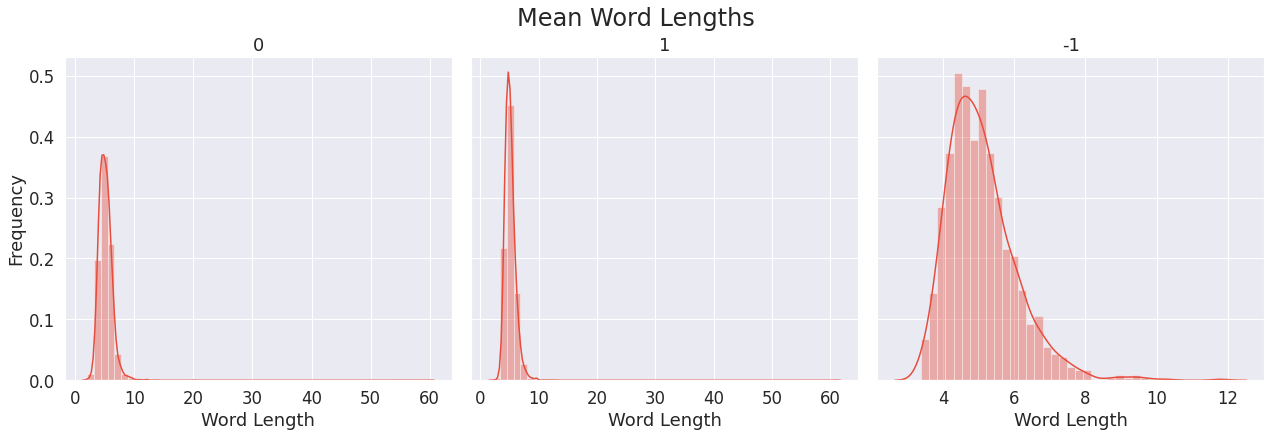

In [27]:
plot_word_len_histogram(train[train['label'] == 0]['safe_text'],
                           train[train['label'] == 1]['safe_text'],
                           train[train['label'] == -1]['safe_text'])

#### Most Common Words

In [28]:
train.head()

,tweet_id,safe_text,label,agreement,tokenized,lower,stops_removed,pos_tags,wordnet_pos,lemmatized,lemma_str,Character Count
0,CL1KWCMY,Me The Big Homie meanboy3000 MEANBOY MB MBS M...,0.0,1.0,"[Me, The, Big, Homie, meanboy3000, MEANBOY, MB...","[me, the, big, homie, meanboy3000, meanboy, mb...","[big, homie, meanboy3000, meanboy, mb, mbs, mm...","[(big, JJ), (homie, NN), (meanboy3000, NN), (m...","[(big, a), (homie, n), (meanboy3000, n), (mean...","[big, homie, meanboy3000, meanboy, mb, mb, mmr...",big homie meanboy3000 meanboy mb mb mmr stegma...,73
1,E3303EME,Im 100 thinking of devoting my career to provi...,1.0,1.0,"[Im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, of, devoting, my, career, ...","[im, 100, thinking, devoting, career, proving,...","[(im, NN), (100, CD), (thinking, VBG), (devoti...","[(im, n), (100, n), (thinking, v), (devoting, ...","[im, 100, think, devote, career, prove, autism...",im 100 think devote career prove autism isnt c...,136
2,M4IVFSMS,whatcausesautism VACCINES DO NOT VACCINATE YOU...,-1.0,1.0,"[whatcausesautism, VACCINES, DO, NOT, VACCINAT...","[whatcausesautism, vaccines, do, not, vaccinat...","[whatcausesautism, vaccines, vaccinate, child]","[(whatcausesautism, NN), (vaccines, NNS), (vac...","[(whatcausesautism, n), (vaccines, n), (vaccin...","[whatcausesautism, vaccine, vaccinate, child]",whatcausesautism vaccine vaccinate child,53
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,"[I, mean, if, they, immunize, my, kid, with, s...","[i, mean, if, they, immunize, my, kid, with, s...","[mean, immunize, kid, something, wont, secretl...","[(mean, JJ), (immunize, VB), (kid, NNS), (some...","[(mean, a), (immunize, v), (kid, n), (somethin...","[mean, immunize, kid, something, wont, secretl...",mean immunize kid something wont secretly kill...,134
4,J77ENIIE,Thanks to Catch me performing at La Nuit NYC ...,0.0,1.0,"[Thanks, to, Catch, me, performing, at, La, Nu...","[thanks, to, catch, me, performing, at, la, nu...","[thanks, catch, performing, la, nuit, nyc, 113...","[(thanks, NNS), (catch, VBP), (performing, VBG...","[(thanks, n), (catch, v), (performing, v), (la...","[thanks, catch, perform, la, nuit, nyc, 1134, ...",thanks catch perform la nuit nyc 1134 1st ave ...,91


In [29]:
lis = [
train[train['label'] == 0]['lemma_str'],
train[train['label'] == 1]['lemma_str'],
train[train['label'] == -1]['lemma_str']
]


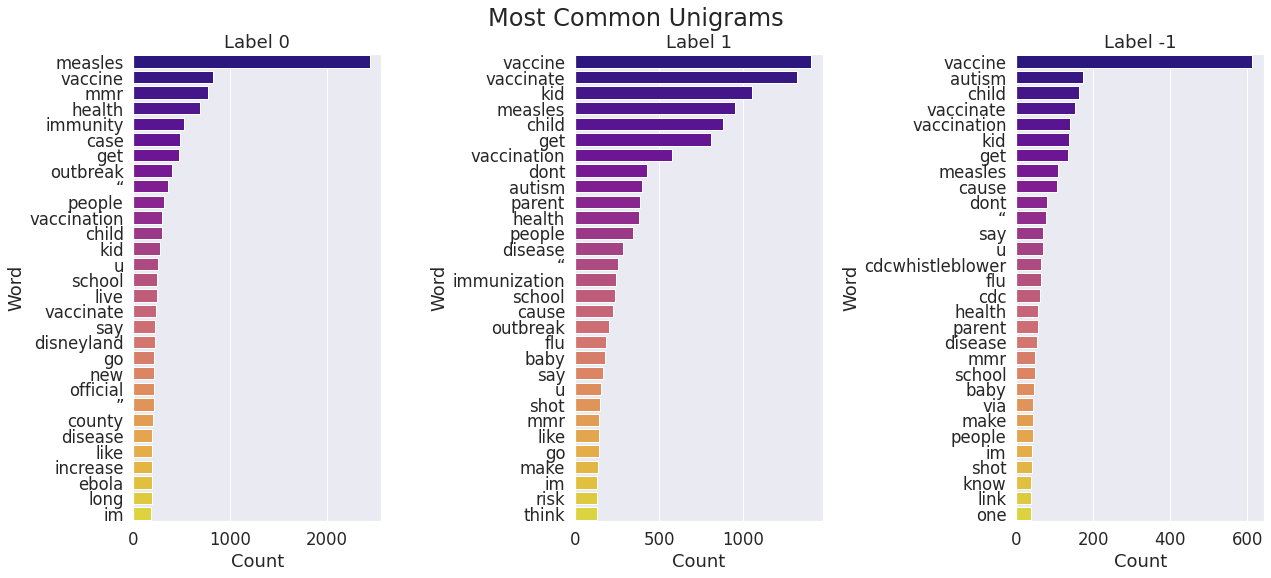

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Label 0')
axes[1].set_title('Label 1')
axes[2].set_title('Label -1')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

#### Most Common Bigrams

In [31]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
            for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Label 0')
        axes[1].set_title('Label 1')
        axes[2].set_title('Label -1')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        axes[2].set_xlabel('Count')
        axes[2].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

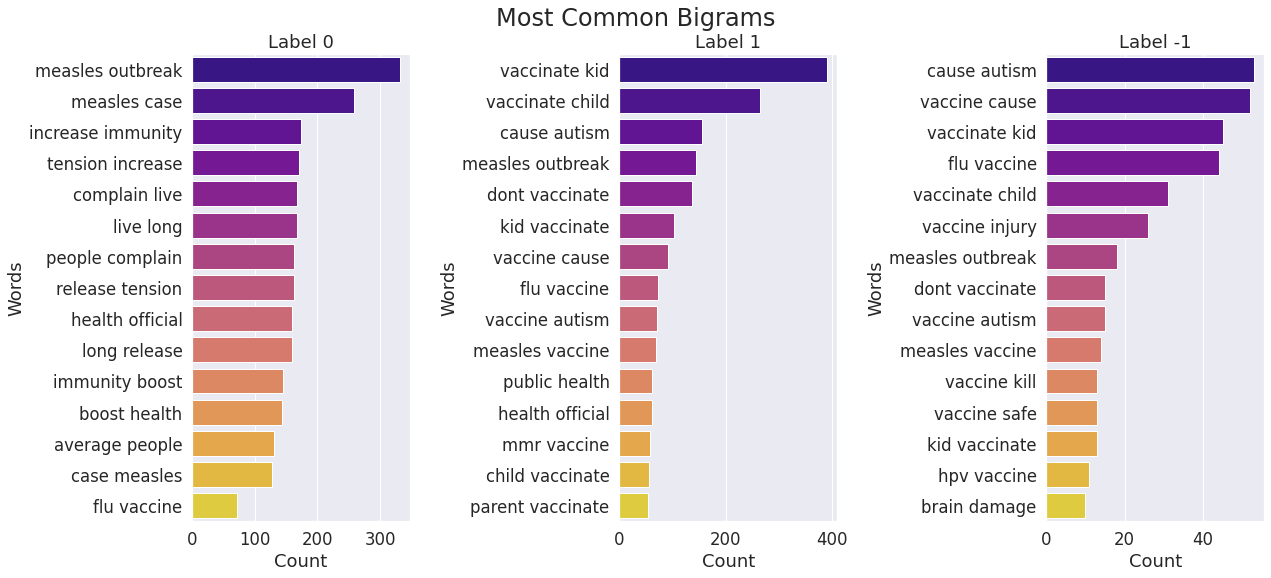

In [32]:
ngrams(2, 'Most Common Bigrams')

### Most comming trigrams

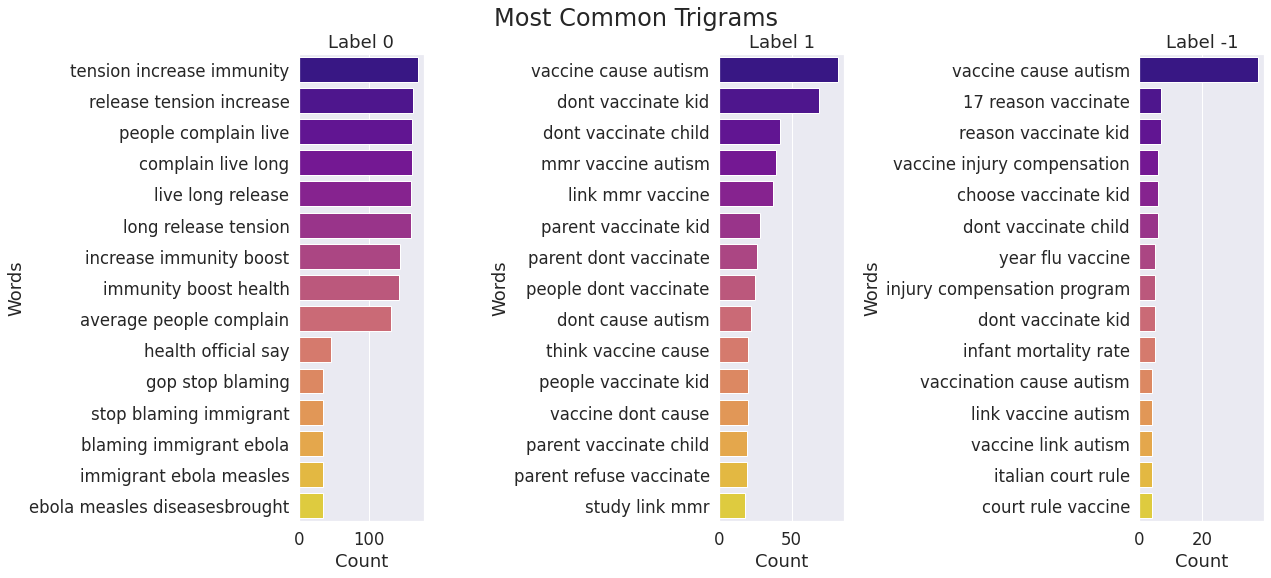

In [33]:
ngrams(3, 'Most Common Trigrams')

### Word Cloud

In [34]:
from google.colab import files
uploaded = files.upload()

mask = np.array(Image.open('twitter.jpeg'))
mask[mask.sum(axis=2) == 0] = 128

Saving twitter.jpeg to twitter (4).jpeg


In [35]:
def plot_wordcloud(text, title, title_size):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        mask=mask,
        contour_width=0.1,
        contour_color='grey',
    ).generate(str(mostcommon))    

    def grey_color_func(word,
                        font_size,
                        position,
                        orientation,
                        random_state=None,
                        **kwargs):
        # A definition for creating grey color shades.
        return 'hsl(0, 0%%, %d%%)' % random.randint(60, 100)

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()


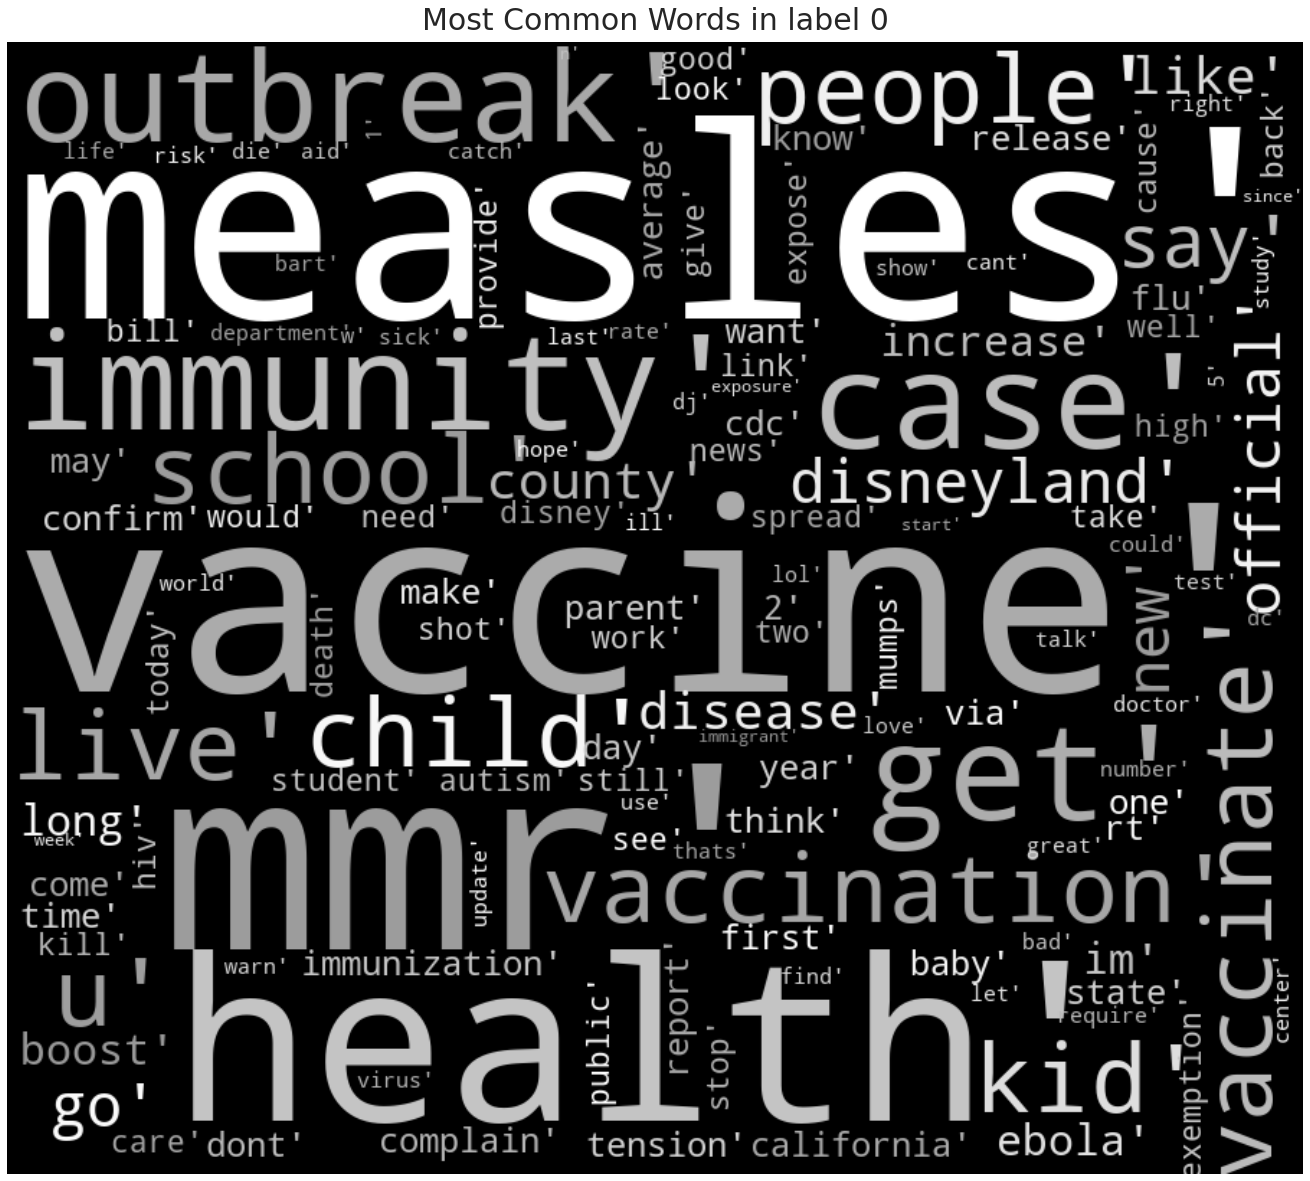

In [36]:


plot_wordcloud(train[train['label'] == 0]['lemmatized'],
               'Most Common Words in label 0',
               title_size=30)



In [37]:


# plot_wordcloud(train[train['label'] == 1]['lemmatized'],
#                'Most Common Words in label 1',
#                title_size=30)



In [38]:


# plot_wordcloud(train[train['label'] == -1]['lemmatized'],
#                'Most Common Words in label -1',
#                title_size=30)



#### Named Entity Recognition

In [39]:
# Loading NER.
nlp = en_core_web_sm.load() 

In [40]:
def plot_named_entity_barchart(text):
    
    """A function for extracting named entities and comparing them"""
    
    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)

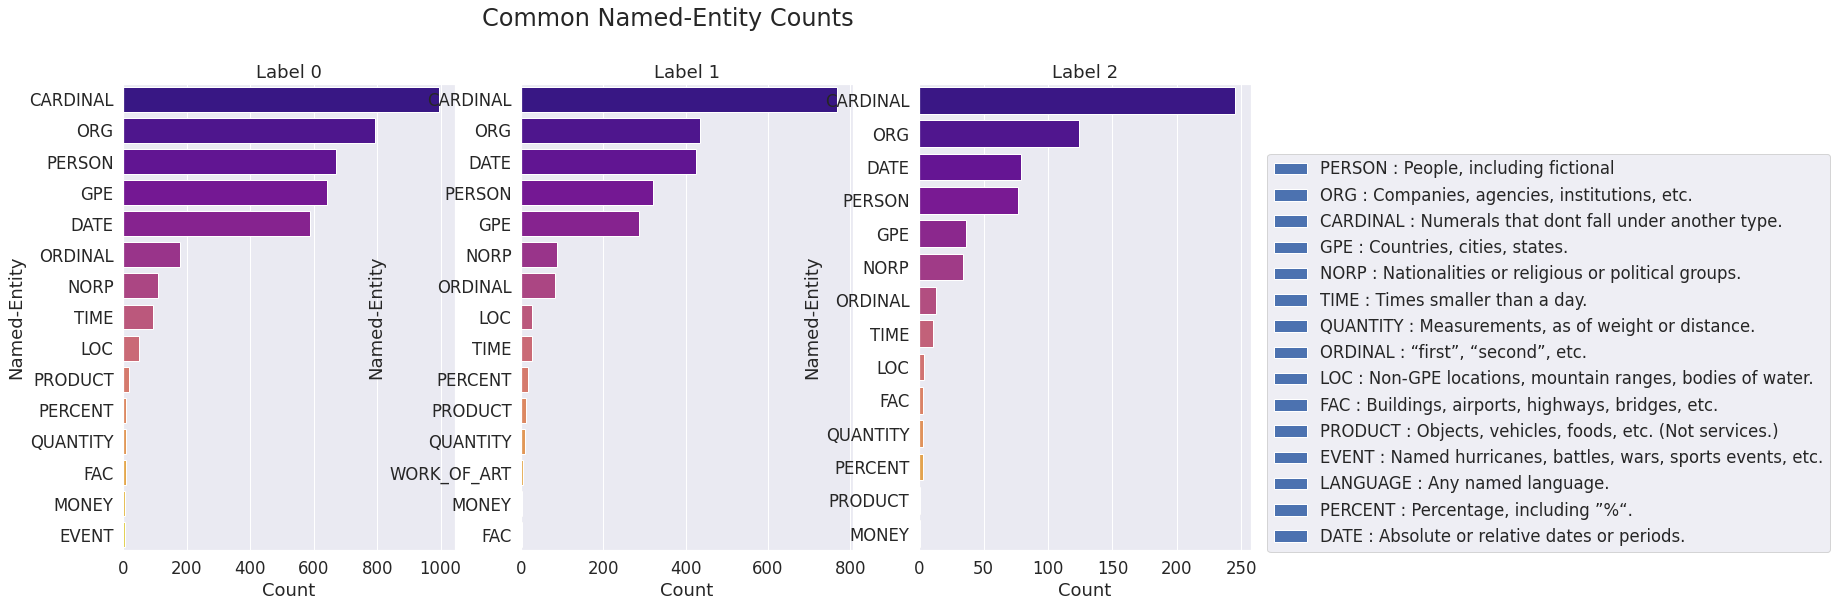

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Label 0')
axes[1].set_title('Label 1')
axes[2].set_title('Label 2')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

### Building the BERT Model